Started NN
Finished NN


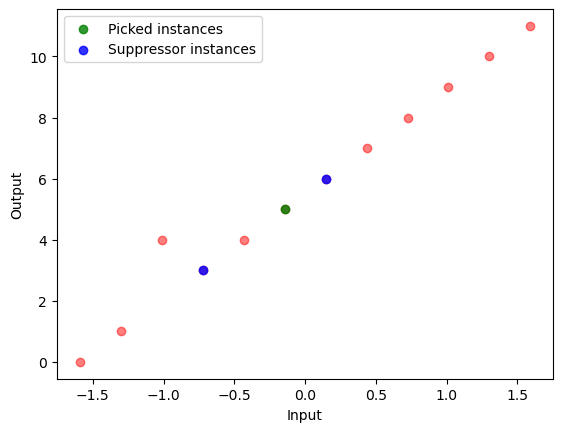

In [14]:
import time
from numpy import zeros, isin, arange, std, abs, array, where
from pandas import DataFrame, concat
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import pandas as pd

class selesup:
    def __init__(self, df, f, alpha, target_col, normalize):
        self.f = f
        self.target_col = target_col
        self.df = df
        self.alpha = alpha
        self.normalize = normalize
         
    def split_dataset(self):
        if self.normalize:
            scaler = StandardScaler()
            columns = [col for col in self.df.columns if col!=self.target_col]
            self.df[columns] = scaler.fit_transform(self.df[columns])
        df_indices = arange(self.df.shape[0])
        # Split the DataFrame into f and 1-f. The split is done in order.
        # Retrieve the indices of WBC and suppression sets
        (self.WBC_indices, self.suppression_set_indices) = train_test_split(df_indices, test_size=1-self.f, shuffle=False)
    
    def Nearest_Neighbors(self):
        X = self.df.drop(columns=['index', self.target_col])
        # Retrieving 3 nearest neighbors for every pathogen
        # We are interested in the first 2 nearest neighbors, we are using k=3 as the pathogen itself is the first nearest neighbour
        nbrs = NearestNeighbors(n_neighbors=3, algorithm='auto').fit(X)
        _, nn_indices = nbrs.kneighbors(self.df.iloc[self.suppression_set_indices].drop(columns=['index', self.target_col]))
        return nn_indices[:, 1:]
    
    def scoring_wbc(self, row):
        self.counter+=1
        X_supp = row.drop([self.target_col])
        y_supp = row[self.target_col]
        supp_index = row.name
        supp_index_nn = row.name - self.suppression_set_indices[0]
        supp_nns = self.nn_indices[supp_index_nn]
        supp_wbc_nn = supp_nns
        # This line used to retrieve the nearest WBC neighbours excluding pathogens, however, it takes time searching for millions of rows
        # For simplicity, we will assume that the nearest neighbours are WBCs ONLY and no pathogens are present as nearest neighbours to the other
        #supp_wbc_nn = supp_nns[np.in1d(supp_nns, self.WBC_indices)]
        first_wbc_nn = self.df.iloc[supp_wbc_nn[0]]
        X_temp = first_wbc_nn.drop(['index', self.target_col])
        X_first = X_temp.values.reshape(-1, X_temp.shape[0])
        y_first = first_wbc_nn[self.target_col]
        second_wbc_nn = self.df.iloc[supp_wbc_nn[1]]
        standard_dev = std([y_supp, second_wbc_nn[self.target_col]])
        theta = self.alpha * standard_dev
        df_supp_nn = self.df.iloc[[supp_index, supp_wbc_nn[1]]]
        X = df_supp_nn.drop(columns=['index', self.target_col]).values
        y = df_supp_nn[self.target_col].values
        reg = LinearRegression().fit(X, y)
        y_pred = reg.predict(X_first)
        # Threshold that determines if the WBC would be considered as representitive
        if abs(y_first - y_pred) < theta:
            self.scores[supp_wbc_nn[0]] += 1
        if self.counter%1000000 == 0:
            print(f"Current counter: {self.counter}. Time since last counter {time.time() - self.start_time}")
            
    def reduce(self, shuffle):
        if shuffle: self.df = self.df.sample(frac=1, random_state=42)  # Set random_state for reproducibility
        self.split_dataset()
        self.df = self.df.reset_index(drop=False)
        # This function retrieves the Nearest Neighbors
        print('Started NN')
        self.nn_indices = self.Nearest_Neighbors()
        print('Finished NN')
        nn_instance = self.nn_indices[0]
        # Nearest neighbors of the suppresor instance from WBC
        wcb_nn = nn_instance[isin(nn_instance, self.WBC_indices)]
        # Nearest neighbors of the suppresor instance from suppresors
        suppressor_nn = nn_instance[~isin(nn_instance, self.WBC_indices)]
        # Initializing zero scores for all the WBC instances
        self.scores = zeros(df.shape[0])
        suppression_set = self.df.iloc[self.suppression_set_indices]
        self.counter=0
        self.start_time = time.time()
        suppression_set.apply(self.scoring_wbc, axis=1)
        # bool_mask for the WBC instances that has scores >=1
        self.chosen_wcb_indices = where(self.scores == 1)[0]
        return self.df.iloc[self.chosen_wcb_indices]

    def draw(self):
        X_full = self.df.drop(columns=['index', self.target_col]).values
        y_full = self.df[self.target_col].values
        X_reduced = self.df.iloc[self.chosen_wcb_indices].drop(columns=['index', self.target_col]).values
        y_reduced = self.df.iloc[self.chosen_wcb_indices][self.target_col].values
        X_supp = self.df.iloc[self.suppression_set_indices].drop(columns=['index', self.target_col]).values
        y_supp = self.df.iloc[self.suppression_set_indices][self.target_col].values 
        plt.scatter(X_full, y_full, color='red', alpha=0.5)
        plt.scatter(X_reduced, y_reduced, label='Picked instances', color='green', alpha=0.8)
        plt.scatter(X_supp, y_supp, label='Suppressor instances', color='blue', alpha=0.8)
        plt.xlabel('Input')
        plt.ylabel('Output')
        plt.legend()
        plt.show()


data = {
    #'X1': list(range(10000000)),
    #'X2': list(range(10000000)),
    #'X3': list(range(10000000)),
    #'X4': list(range(10000000)),
    'X1': list(range(12)),
    'pressure': [0, 1, 4, 3, 4, 5, 6, 7, 8, 9, 10, 11]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Create an instance of selesup
start = time.time()
algorithm = selesup(df, f=0.90, alpha=2, target_col='pressure', normalize=True)
reduced_df = algorithm.reduce(shuffle=True)
#print(f"Time taken: {round(time.time()-start, 2)} sec")
algorithm.draw()
